# 연직단면도 그리기


In [67]:
# 자료 내려받기
from siphon.simplewebservice.wyoming import WyomingUpperAir
import cdsapi

# 자료 다루기
from datetime import datetime
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
from metpy.interpolate import cross_section
from scipy.ndimage import gaussian_filter

# 그림 그리기
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 사례에 대해 자료 받기

In [68]:
dt = datetime(2019,9,7,0)
path = '/Users/hojjunekim/Desktop/Final_project/'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'
fname2 = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'


In [83]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [0.25, 0.25],
        
    },
    path + fname1)

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind', 'specific_humidity'],
        'pressure_level': 
        ['200', '300', '500','600','700','850', '925','1000'],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [0.25, 0.25],
    },
    path + fname2)

2020-12-02 00:21:37,995 INFO Welcome to the CDS
2020-12-02 00:21:37,996 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-12-02 00:21:39,289 INFO Request is queued
2020-12-02 00:21:40,580 INFO Request is running
2020-12-02 00:21:42,382 INFO Request is completed
2020-12-02 00:21:42,384 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data5/adaptor.mars.internal-1606836099.5312827-30042-33-38c4782b-0ca5-4b23-b0cf-c649db1973a0.nc to /Users/hojjunekim/Desktop/snu_weatheranalysis-master/era5_sfc_2019090600.nc (4M)
2020-12-02 00:21:47,026 INFO Download rate 876K/s   
2020-12-02 00:21:48,622 INFO Welcome to the CDS
2020-12-02 00:21:48,623 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-12-02 00:21:48,963 INFO Request is queued
2020-12-02 00:21:50,246 INFO Request is running
2020-12-02 00:21:54,582 INFO Request is completed
2020-12-02 00:21:54,582 INFO Dow

Result(content_length=83070276,content_type=application/x-netcdf,location=http://136.156.133.32/cache-compute-0009/cache/data9/adaptor.mars.internal-1606836108.9950948-8207-22-eb61ffc8-a5f4-437b-8c0c-4573c9cd38c5.nc)

In [69]:
ds1 = xr.open_dataset(path+fname1)
ds2 = xr.open_dataset(path+fname2)

# Select and grab data, at/lon values 
lvl = 300
g = 9.806
msl = ds1['msl'].sel(time=dt,latitude=slice(90,0), longitude=slice(60,201))[...]
gh = ds2['z'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
t = ds2['t'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
u = ds2['u'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
v = ds2['v'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
lats = msl.latitude.data
lons = msl.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
msl = gaussian_filter(msl.data, sigma=0) / 100. * units('hPa')
gh = gaussian_filter(gh.data, sigma=0) / g *units('m')
u = gaussian_filter(u.data, sigma=0) * units('m/s')
v = gaussian_filter(v.data, sigma=0) * units('m/s')
t = gaussian_filter(t.data, sigma=0) * units('K')
wind = mpcalc.wind_speed(u, v).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds1.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

# 지상, 상층 일기도 그리기

<ipython-input-72-d19e86598b43>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.975, 0.99])
<ipython-input-72-d19e86598b43>:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=[0, 0, 0.975, 0.99])


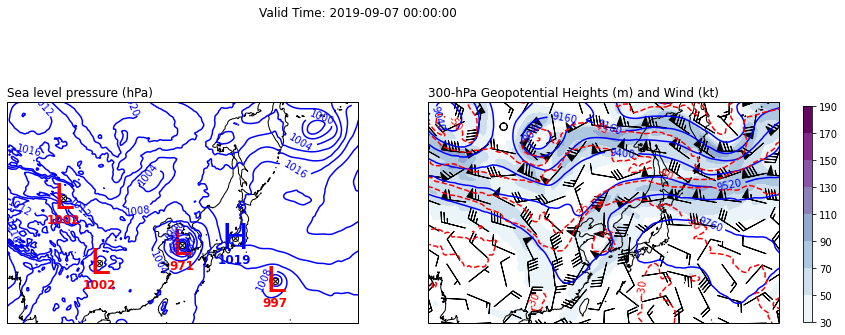

In [72]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(13, 6))
ax = fig.add_subplot(121, projection=mapcrs)

## Surface
domain = [90, 160, 20, 60]
ax.set_extent(domain, ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, msl.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(ax, lons, lats, domain, msl.m, 'max', 80,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(ax, lons, lats, domain, msl.m, 'min', 80,
                   symbol='L', color='red', transform=ccrs.PlateCarree())

# Make some nice titles for the plot (one right, one left)
ax.set_title('Sea level pressure (hPa)',
           loc='left')

## pressure level
ax2 = fig.add_subplot(122, projection=mapcrs)
ax2.set_extent(domain, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.STATES.with_scale('50m'))

# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_wind = np.arange(30, 200, 20)
cf = ax2.contourf(lons, lats, wind, clevs_wind, cmap=plt.cm.BuPu,
                 transform=datacrs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.25, 0.01, 0.5])
fig.colorbar(cf, orientation='vertical', shrink=0.5, cax=cbar_ax)

# Plot 500-hPa Geopotential Heights in meters
clevs_gh = np.arange(40, 15000, 120)
cs = ax2.contour(lons, lats, gh, clevs_gh, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa temperatue in degC
clevs_t = np.arange(-60, 5, 5)
cs = ax2.contour(lons, lats, t.to('degC'), clevs_t, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax2.barbs(lons, lats, u.to('kt').m, v.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)

# Make some nice titles for the plot (one right, one left)
ax2.set_title('300-hPa Geopotential Heights (m) and Wind (kt)'
              ,loc='left')
fig.suptitle('Valid Time: {}'.format(vtime))

# Adjust image and show
fig.tight_layout(rect=[0, 0, 0.975, 0.99])

In [71]:
def plot_maxmin_points(ax, lon, lat, domain, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        if (lon[mxx[i], mxy[i]] > domain[0]) & (lon[mxx[i], mxy[i]] < domain[1]) & (lat[mxx[i], mxy[i]] > domain[2]) & (lat[mxx[i], mxy[i]] < domain[3]):
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
            ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
            ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

# 연직단면도 그리기

In [45]:
dt = datetime(2019,9,7,0)
path = '/Users/hojjunekim/Desktop/Final_project/'
fname1 = 'era5_sfc_' + dt.strftime("%Y%m%d%H") + '.nc'
fname2 = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'

ds1 = xr.open_dataset(path+fname1)
ds2 = xr.open_dataset(path+fname2)

data = ds2.metpy.parse_cf()
start = (45., 125.)
end = (30., 125.)
cross = cross_section(data, start, end)
cross.set_coords(('latitude','longitude'))

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


<xarray.Dataset>
Dimensions:    (index: 100, level: 8, time: 1)
Coordinates:
  * level      (level) int32 200 300 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2019-09-07
    crs        object Projection: latitude_longitude
    longitude  (index) float64 125.0 125.0 125.0 125.0 ... 125.0 125.0 125.0
    latitude   (index) float64 45.0 44.85 44.7 44.55 ... 30.46 30.3 30.15 30.0
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    t          (time, level, index) float64 220.8 220.9 221.0 ... 299.9 300.0
    z          (time, level, index) float64 1.206e+05 1.206e+05 ... 387.4 395.7
    u          (time, level, index) float64 38.28 37.37 36.5 ... 8.366 8.057
    v          (time, level, index) float64 39.51 39.04 38.55 ... 1.44 1.111
    q          (time, level, index) float64 9.265e-05 9.317e-05 ... 0.01765
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-29 17:35:43 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [46]:
temperature, pressure, specific_humidity = xr.broadcast(cross['t'],
                                                        cross['level'],
                                                        cross['q'])

theta = mpcalc.potential_temperature(pressure, temperature)
rh = mpcalc.relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure)

# These calculations return unit arrays, so put those back into DataArrays in our Dataset
cross['Potential_temperature'] = xr.DataArray(theta,
                                              coords=temperature.coords,
                                              dims=temperature.dims,
                                              attrs={'units': theta.units})
cross['Relative_humidity'] = xr.DataArray(rh,
                                          coords=specific_humidity.coords,
                                          dims=specific_humidity.dims,
                                          attrs={'units': rh.units})

cross['u'].metpy.convert_units('m/s')
cross['v'].metpy.convert_units('m/s')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u'],
                                                         cross['v'])

print(cross)

<xarray.Dataset>
Dimensions:                (index: 100, level: 8, time: 1)
Coordinates:
  * level                  (level) int32 200 300 500 600 700 850 925 1000
  * time                   (time) datetime64[ns] 2019-09-07
    crs                    object Projection: latitude_longitude
    longitude              (index) float64 125.0 125.0 125.0 ... 125.0 125.0
    latitude               (index) float64 45.0 44.85 44.7 ... 30.3 30.15 30.0
  * index                  (index) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    t                      (time, level, index) float64 220.8 220.9 ... 300.0
    z                      (time, level, index) float64 1.206e+05 ... 395.7
    u                      (time, level, index) float64 38.28 37.37 ... 8.057
    v                      (time, level, index) float64 39.51 39.04 ... 1.111
    q                      (time, level, index) float64 9.265e-05 ... 0.01765
    Potential_temperature  (time, level, index) float64 <Quantity([[[349

<xarray.DataArray 'n_wind' (time: 1, level: 8, index: 100)>
array([[[ 3.82798080e+01,  3.73681162e+01,  3.64958373e+01,
          3.56974537e+01,  3.48693605e+01,  3.40258071e+01,
          3.31286233e+01,  3.22715629e+01,  3.14767300e+01,
          3.08912503e+01,  3.03927089e+01,  3.00330558e+01,
          2.95562071e+01,  2.89283037e+01,  2.78388684e+01,
          2.65768997e+01,  2.50149432e+01,  2.36352800e+01,
          2.24512515e+01,  2.18924227e+01,  2.15422575e+01,
          2.15642080e+01,  2.15333102e+01,  2.14552588e+01,
          2.11311093e+01,  2.07576410e+01,  2.03332023e+01,
          1.98498166e+01,  1.93229014e+01,  1.84791619e+01,
          1.75183981e+01,  1.63156661e+01,  1.50635311e+01,
          1.37814444e+01,  1.25775790e+01,  1.14033791e+01,
          1.02871083e+01,  9.24772724e+00,  8.24958402e+00,
          7.42115989e+00,  6.63783253e+00,  5.93137770e+00,
          5.15643539e+00,  4.34236892e+00,  3.36130878e+00,
          2.35568672e+00,  1.31600341e+0

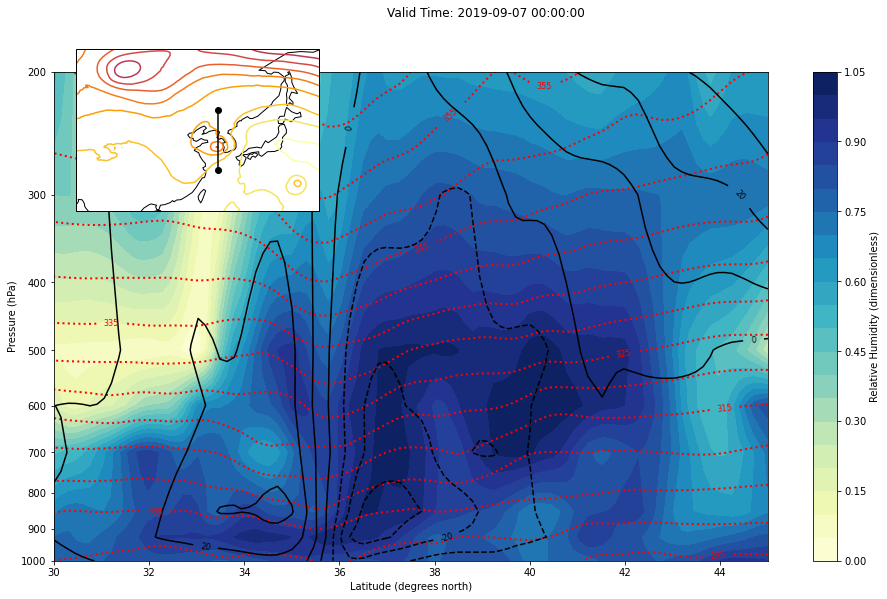

In [63]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

g = 9.806
# Plot RH using contourf
rh_contour = ax.contourf(cross['latitude'], cross['level'][::-1], cross['Relative_humidity'].sel(time=dt)[::-1,:],
                         levels=np.arange(0, 1.1, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['latitude'], cross['level'][::-1], cross['Potential_temperature'].sel(time=dt)[::-1,:],
                           levels=np.arange(250, 450, 5), colors='r', linestyles='dotted', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='r', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)
print(cross['n_wind'])
wind_contour = ax.contour(cross['latitude'], cross['level'][::-1],
               cross['n_wind'].sel(time=dt)[::-1,:], levels=np.arange(-50,150,10), colors='k')
wind_contour.clabel(wind_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)


# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 150, -100))
ax.set_ylim(cross['level'].max(), cross['level'].min())
ax.set_yticks(np.arange(1000, 150, -100))

# Define the CRS and inset axes
#data_crs = data['z'].metpy.cartopy_crs
datacrs = ccrs.PlateCarree()
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=datacrs)
ax_inset.set_extent([90, 150, 20, 60], datacrs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['longitude'].sel(longitude=slice(60,201)), data['latitude'].sel(latitude=slice(90,0)),
                 data['z'].sel(time=dt, level=500., latitude=slice(90,0), longitude=slice(60,201))/g,
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = datacrs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), '
#             'Relative Humidity (dimensionless)\n'
#             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
#                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Latitude (degrees north)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

fig.suptitle('Valid Time: {}'.format(dt))

plt.show()